# 실험 준비

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import winsound

In [2]:
from src.models.BaseAutoEncoder import BaseSeq2Seq
from src.dataload.tabular import tabularDataset
from src.utils import inference
from src.simulation_trainer import BaseTrainer, NewTrainer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import random

C:\Users\ghktj\anaconda3\envs\pytorch\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal]).reset_index(drop=True)
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )

In [4]:
from argparse import Namespace

config = {
    'trainer_name' : 'BaseTrainer',
    'train_ratio': .7,
    'batch_size': 512,
    'n_epochs': 1000,
    'early_stop_round': 50,
    # 'hidden_size': [2, 4], # -> 더 큰 데이터에서 4를 진행해야 할 듯 (나중에 benchmark?)
    'hidden_size': [2],
    'window_size': 60,
    'data': 'tabular',
    'sampling_term': [1, 5],
    'initial_epochs': [5, 10],
    'sampling_ratio': [0.01, 0.1]
}

# gpu
gpu_id = 0 if torch.cuda.is_available() else -1

if gpu_id == 0:
    config['device'] = 'cuda:0'
else:
    config['device'] = 'cpu'

config = Namespace(**config)

print(config)

Namespace(batch_size=512, data='tabular', device='cuda:0', early_stop_round=50, hidden_size=[2, 4], initial_epochs=[5, 10], n_epochs=1000, sampling_ratio=[0.01, 0.1], sampling_term=[1, 5], train_ratio=0.7, trainer_name='BaseTrainer', window_size=60)


In [5]:
torch.backends.cudnn.deterministic = True
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [6]:
import os

PATH = './sim_data'
file_list = os.listdir(PATH)
file_list_csv = [file for file in file_list if file.endswith('.csv')]
file_list_csv

['bigNormal.csv',
 'bigTestNoise_010_01.csv',
 'bigTestNoise_010_05.csv',
 'bigTestNoise_010_09.csv',
 'bigTrainNoise_001_01.csv',
 'bigTrainNoise_001_05.csv',
 'bigTrainNoise_001_09.csv',
 'bigTrainNoise_010_01.csv',
 'bigTrainNoise_010_05.csv',
 'bigTrainNoise_010_09.csv',
 'smallNormal.csv',
 'smallTestNoise_010_01.csv',
 'smallTestNoise_010_05.csv',
 'smallTestNoise_010_09.csv',
 'smallTrainNoise_001_01.csv',
 'smallTrainNoise_001_05.csv',
 'smallTrainNoise_001_09.csv',
 'smallTrainNoise_010_01.csv',
 'smallTrainNoise_010_05.csv',
 'smallTrainNoise_010_09.csv']

- 저장해야 할 것
  - epoch=500일 때만
    - top, down
    - error
  - 항상
    - 모델 성능 result

### 시간이 너무 오래걸려서
- big은 제외하고 일단 진행 -> 사이즈를 줄이던지 교수님들한테 피드백받고 추가하자
- **weight=0.5는 제외**하고 일단 진행
- small에서 hidden_size=4의 경우는 데이터가 부족한 것 같다. 일단은 **h=4는 제외**하고 진행

### 일지 (1회당 1시간 걸림, 일단 3회 진행)
- `smallNormal.csv`
    - epoch=1000 & early_stop=50: 2회 진행
    - epoch=500
- `smallTestNoise_010_01.csv`
- `smallTestNoise_010_09.csv`
- `smallTestNoise_010_05.csv`
- `smallTrainNoise_001_01.csv`
- `smallTrainNoise_001_05.csv`
- `smallTrainNoise_001_09.csv`
- `smallTrainNoise_010_01.csv`
- `smallTrainNoise_010_05.csv`
- `smallTrainNoise_010_09.csv`

In [7]:
data_list = ['smallNormal.csv']
# 데이터 하나씩 하자 cache에 영향이 있을 듯

n_time = 1

# 모델 성능 결과 저장 경로
PATH = './run_result_sim/'

for d in data_list:
    df = pd.read_csv('./sim_data/' + d)
    config.data_name = d.split('.')[0]
    for i in range(n_time):
        print(f'<< {i+1}번재 시작 >>')
        (
            train_x,
            valid_x,
            test_x,
            train_y,
            valid_y,
            test_y,
        ) = simul_split_train_valid_test(df, config.train_ratio)
        
        # resize 'window_size' = 'col_len'
        config.window_size = train_x.shape[1]

        train_dataset = tabularDataset(train_x, train_y)
        valid_dataset = tabularDataset(valid_x, valid_y)
        test_dataset = tabularDataset(test_x, test_y)

        train_dataloader = DataLoader(
            train_dataset, shuffle=False, batch_size=config.batch_size
        )
        valid_dataloader = DataLoader(
            valid_dataset, shuffle=False, batch_size=config.batch_size
        )
        test_dataloader = DataLoader(
            test_dataset, shuffle=False, batch_size=config.batch_size
        )

        total_x = np.concatenate([train_x, valid_x, test_x])
        total_y = np.concatenate([train_y, valid_y, test_y])
        IR = round((len(total_y) - np.sum(total_y)) / np.sum(total_y), 4)
        
        # for inference
        total_dataset = tabularDataset(total_x, total_y)
        total_dataloader = DataLoader(
            total_dataset, shuffle=False, batch_size=config.batch_size
        )

        for hidden_size in config.hidden_size:
            print(f"-----BaseTrainer starts with hidden_size={hidden_size}-----")
            config.trainer_name = "BaseTrainer"

            model = BaseSeq2Seq(
                input_size=config.window_size,
                hidden_size=hidden_size,
                output_size=config.window_size,
                dropout_p=0.2,
            ).to(config.device)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()

            # train
            trainer = BaseTrainer(model=model, optimizer=optimizer, crit=criterion)

            train_loss, val_loss, return_epoch, best_model = trainer.train(
                train_loader=train_dataloader,
                val_loader=valid_dataloader,
                config=config,
                use_wandb=False,
            )

            best_model.to("cpu")                        
            sampling_term = 0
            sampling_ratio = 0
            initial_epoch = 0

            df = inference(
                config,
                total_dataloader,
                best_model,
                train_x,
                valid_x,
                total_x,
                total_y,
                return_epoch,
                hidden_size,
                train_loss,
                val_loss,
                IR,
                sampling_term,
                sampling_ratio,
                initial_epoch,
                PATH
            )

            df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)
            torch.cuda.empty_cache()
            
        for hidden_size in config.hidden_size:
            for sampling_ratio in config.sampling_ratio:
                for initial_epoch in config.initial_epochs: 
                    for sampling_term in config.sampling_term:
                        print(
                            f"-----NewTrainer starts-----"
                        )
                        config.trainer_name = "NewTrainer"

                        model = BaseSeq2Seq(
                            input_size=config.window_size,
                            hidden_size=hidden_size,
                            output_size=config.window_size,
                            dropout_p=0.2,
                        ).to(config.device)

                        optimizer = optim.Adam(model.parameters())
                        criterion = nn.MSELoss()

                        # train
                        trainer = NewTrainer(model=model, optimizer=optimizer, crit=criterion)
                        
                        # 500epoch이고 train에 noise가 있는 경우에만 error, top, down 확인
                        if (config.n_epochs == 500) and ('Train' in config.data_name):
                            is_debug = True
                        else:
                            is_debug = False
                        
                        train_loss, val_loss, return_epoch, best_model, errors, tops, downs = trainer.train(
                            train_x=train_x,
                            train_y=train_y,
                            train_loader=train_dataloader,
                            val_loader=valid_dataloader,
                            sampling_term=sampling_term,
                            initial_epoch=initial_epoch,
                            sampling_ratio=sampling_ratio,
                            config=config,
                            use_wandb=False,
                            is_debug=is_debug
                        )
                        if is_debug:
                            hp = '_h' + str(hidden_size) + '_st' + str(sampling_term) + '_sr' + str(sampling_ratio) + '_ie' + str(initial_epoch)
                            with open('./run_result_sim_error/newError_'+ config.data_name + hp +  '.pickle', 'wb') as f:
                                pickle.dump(errors, f, pickle.HIGHEST_PROTOCOL)
                            with open('./run_result_sim_top/newTop_'+ config.data_name + hp + '.pickle', 'wb') as f:
                                pickle.dump(tops, f, pickle.HIGHEST_PROTOCOL)
                            with open('./run_result_sim_down/newDown_'+ config.data_name + hp + '.pickle', 'wb') as f:
                                pickle.dump(downs, f, pickle.HIGHEST_PROTOCOL)
                        
                        best_model.to("cpu")                                

                        df = inference(
                            config,
                            total_dataloader,
                            best_model,
                            train_x,
                            valid_x,
                            total_x,
                            total_y,
                            return_epoch,
                            hidden_size,
                            train_loss,
                            val_loss,
                            IR,
                            sampling_term,
                            sampling_ratio,
                            initial_epoch,
                            PATH
                        )
                        df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)
                        torch.cuda.empty_cache()
                        
frequency = 800
duration = 2000
winsound.Beep(frequency, duration)

<< 1번재 시작 >>
-----BaseTrainer starts with hidden_size=2-----


<ipython-input-3-c9eb5218e970>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


Early Stopped! in Epoch 132:
train_loss=0.811, valid_loss=0.801
-----BaseTrainer starts with hidden_size=4-----
Early Stopped! in Epoch 276:
train_loss=0.661, valid_loss=0.573
-----NewTrainer starts-----
Early Stopped! in Epoch 154:
train_loss=0.797, valid_loss=0.767
-----NewTrainer starts-----
Early Stopped! in Epoch 130:
train_loss=0.799, valid_loss=0.775
-----NewTrainer starts-----
Early Stopped! in Epoch 618:
train_loss=0.758, valid_loss=0.701
-----NewTrainer starts-----
Early Stopped! in Epoch 146:
train_loss=0.766, valid_loss=0.731
-----NewTrainer starts-----
Early Stopped! in Epoch 82:
train_loss=0.749, valid_loss=0.813
-----NewTrainer starts-----
Early Stopped! in Epoch 779:
train_loss=0.723, valid_loss=0.705
-----NewTrainer starts-----
Early Stopped! in Epoch 388:
train_loss=0.726, valid_loss=0.716
-----NewTrainer starts-----
Early Stopped! in Epoch 400:
train_loss=0.718, valid_loss=0.702
-----NewTrainer starts-----
Early Stopped! in Epoch 363:
train_loss=0.657, valid_loss=0.5

In [15]:
cols = ['trainer_name', 'hidden_size','sampling_term','sampling_ratio','initial_epoch']
pd.read_csv('./run_result_sim/result_smallNormal.csv').groupby(cols)[['roc_auc','pr_auc','return_epoch']].agg(['mean','std'])

roc_auc  \
                                                                        mean   
trainer_name hidden_size sampling_term sampling_ratio initial_epoch            
BaseTrainer  2           0             0.00           0              0.70950   
             4           0             0.00           0              0.81390   
NewTrainer   2           1             0.01           5              0.70525   
                                                      10             0.73480   
                                       0.10           5              0.70570   
                                                      10             0.72030   
                         5             0.01           5              0.71360   
                                                      10             0.73310   
                                       0.10           5              0.71465   
                                                      10             0.73370   
             4           1             0.01           5              0.80695   
                                                      10             0.79190   
                                       0.10           5              0.79645   
                                                      10             0.79505   
                         5             0.01           5              0.80685   
                                                      10             0.80780   
                                       0.10           5              0.79590   
                                                      10             0.80115   

                                                                               \
                                                                          std   
trainer_name hidden_size sampling_term sampling_ratio initial_epoch             
BaseTrainer  2           0             0.00           0              0.006647   
             4           0             0.00           0              0.011738   
NewTrainer   2           1             0.01           5              0.000495   
                                                      10             0.013435   
                                       0.10           5              0.023617   
                                                      10             0.016405   
                         5             0.01           5              0.002970   
                                                      10             0.000424   
                                       0.10           5              0.021991   
                                                      10             0.003394   
             4           1             0.01           5              0.015910   
                                                      10             0.018526   
                                       0.10           5              0.029345   
                                                      10             0.026375   
                         5             0.01           5              0.006435   
                                                      10             0.005233   
                                       0.10           5              0.002263   
                                                      10             0.014071   

                                                                      pr_auc  \
                                                                        mean   
trainer_name hidden_size sampling_term sampling_ratio initial_epoch            
BaseTrainer  2           0             0.00           0              0.63740   
             4           0             0.00           0              0.78205   
NewTrainer   2           1             0.01           5              0.63615   
                                                      10             0.67475   
                                       0.10           5              0.63870   
                                              

# top, down 확인
- 근데 생각해보니까 Base랑 비교할 이유는 없음 어차피 Base도 잘 될 거임
- noise의 수보다 많이 sampling하면 문제 발생 ㅇㅇ
- noise ratio 1%
  - sampling되서 빠지는 애들이 noise가 아닌 경우가 많다.
- noise ratio 10%
  - ??

In [8]:
from sklearn.manifold import TSNE

### weight 0.1

In [9]:
data_list = ['dirty_df_2_ratio0.7_weight0.1.csv','dirty_df_2_ratio0.7_weight0.5.csv', 'dirty_df_2_ratio0.7_weight0.9.csv']

noise_df = pd.read_csv('./sim_data/' + data_list[0])
(
    train_x,
    _,
    _,
    _,
    _,
    _,
) = simul_split_train_valid_test(noise_df, 0.7)

FileNotFoundError: [Errno 2] File ./sim_data/dirty_df_2_ratio0.7_weight0.1.csv does not exist: './sim_data/dirty_df_2_ratio0.7_weight0.1.csv'

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(train_x)

In [ ]:
def show_top_down(epoch):
    idx = epoch + config.initial_epochs[0]
    plt.subplots(1,2, figsize=(16,5))

    color = np.zeros(len(train_x))
    color= pd.Series(color)
    color[down[:, idx]] = 1
    plt.subplot(121)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, s=color*30+10)
    plt.title(f'NewTrainer in epoch={idx}, high recon-error data (yellow)')

    color = np.zeros(len(train_x))
    color= pd.Series(color)
    color[top[:, idx]] = 1
    plt.subplot(122)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, s=color*30+10)
    plt.title(f'NewTrainer in epoch={idx}, low recon-error data (yellow)')

In [ ]:
import pickle

# load
with open('./sim_weight_top_down/New_downs_sampling_out_dirty_df_2_ratio07_weight01.pickle', 'rb') as f:
    down = pickle.load(f)
    
with open('./sim_weight_top_down/New_tops_sampling_out_dirty_df_2_ratio07_weight01.pickle', 'rb') as f:
    top = pickle.load(f)
    
with open('./sim_data/choice_idx_2_ratio0.7_weight0.1.pickle', 'rb') as f:
    choice= pickle.load(f)

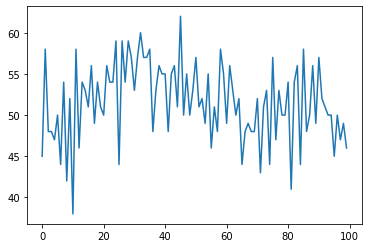

In [ ]:
num_noise_out = []
for i in range(100):
    sum_noise_out = pd.Series(down[:, i]).map(lambda x : x in choice).sum()
    num_noise_out.append(sum_noise_out)
plt.plot(num_noise_out)

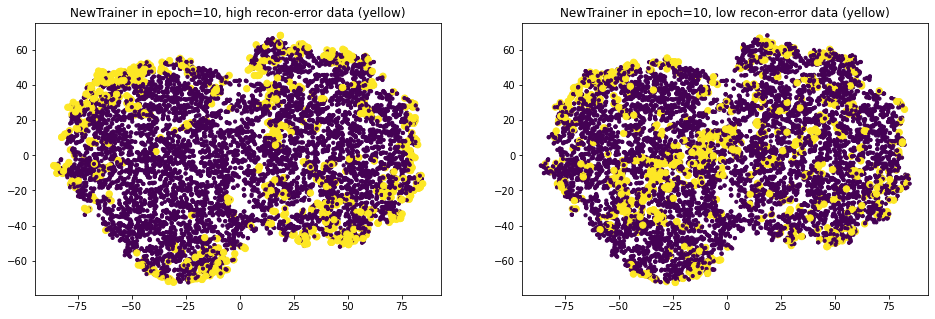

In [ ]:
show_top_down(0)

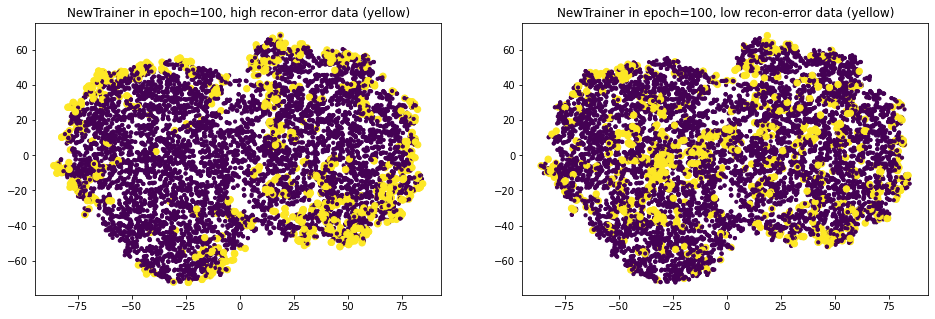

In [ ]:
show_top_down(90)

### weight 0.5

In [ ]:
import pickle

# load
with open('./sim_weight_top_down/New_downs_sampling_out_dirty_df_2_ratio07_weight05.pickle', 'rb') as f:
    down = pickle.load(f)
    
with open('./sim_weight_top_down/New_tops_sampling_out_dirty_df_2_ratio07_weight05.pickle', 'rb') as f:
    top = pickle.load(f)
    
with open('./sim_data/choice_idx_2_ratio0.7_weight0.5.pickle', 'rb') as f:
    choice= pickle.load(f)

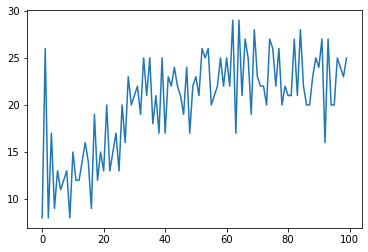

In [ ]:
num_noise_out = []
for i in range(100):
    sum_noise_out = pd.Series(down[:, i]).map(lambda x : x in choice).sum()
    num_noise_out.append(sum_noise_out)
plt.plot(num_noise_out)

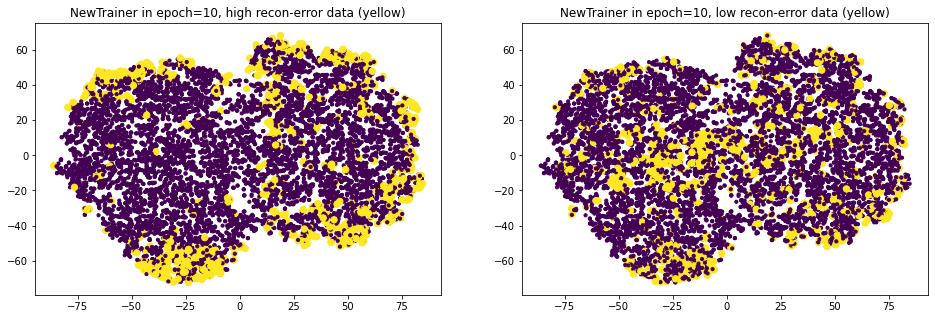

In [ ]:
show_top_down(0)

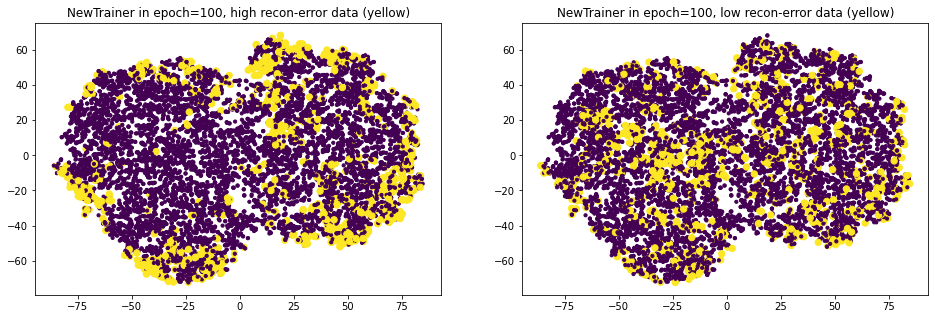

In [ ]:
show_top_down(90)

### weight 0.9

In [ ]:
import pickle

# load
with open('./sim_weight_top_down/New_downs_sampling_out_dirty_df_2_ratio07_weight09.pickle', 'rb') as f:
    down = pickle.load(f)
    
with open('./sim_weight_top_down/New_tops_sampling_out_dirty_df_2_ratio07_weight09.pickle', 'rb') as f:
    top = pickle.load(f)

In [ ]:
with open('./sim_data/choice_idx_2_ratio0.7_weight0.9.pickle', 'rb') as f:
    choice= pickle.load(f)

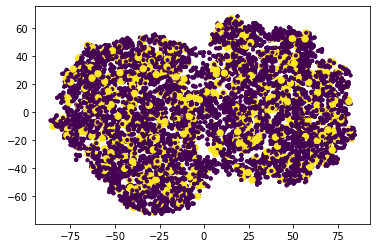

In [ ]:
color = np.zeros(len(train_x))
color= pd.Series(color)
for c in choice:
    if c < len(train_x):    
        color[c] = 1

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, s=color*30+10)

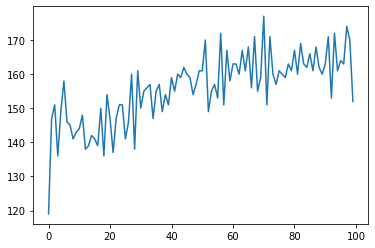

In [ ]:
num_noise_out = []
for i in range(100):
    sum_noise_out = pd.Series(down[:, i]).map(lambda x : x in choice).sum()
    num_noise_out.append(sum_noise_out)
plt.plot(num_noise_out)

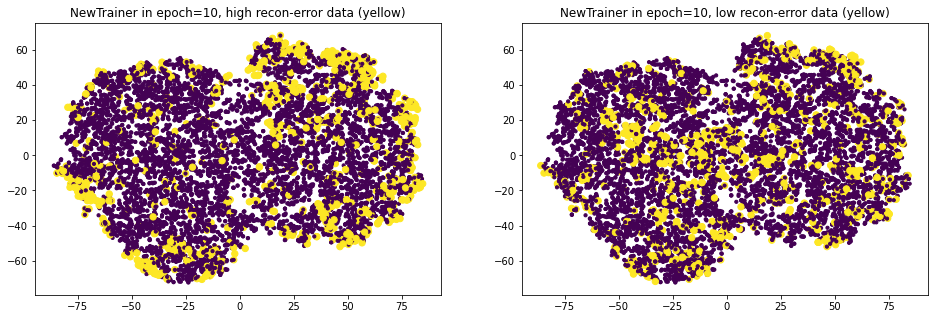

In [ ]:
show_top_down(0)

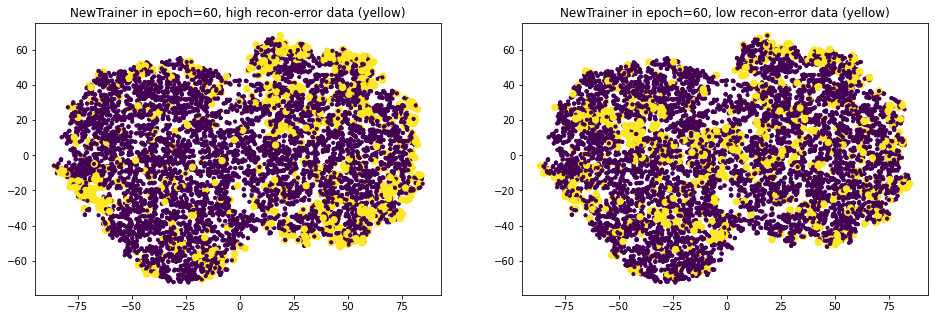

In [ ]:
show_top_down(50)

# error 시각화

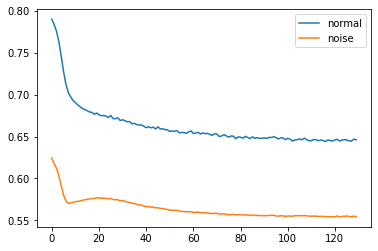

In [ ]:
# load
with open('./sim_weight_top_down/Base_errors_sampling_out_dirty_df_2_ratio07_weight05.pickle', 'rb') as f:
    error = pickle.load(f)
    
# load
with open('./sim_data/choice_idx_2_ratio0.7_weight0.5.pickle', 'rb') as f:
    choice_idx = pickle.load(f)
    
tmp = pd.DataFrame(error[:, :130])
tmp['noise'] = 0
for idx in choice_idx:
    if idx < tmp.shape[0]:
        tmp.iloc[idx, -1] = 1
        
normal = tmp.groupby('noise').mean().values[0]
noise = tmp.groupby('noise').mean().values[1]

plt.plot(normal)
plt.plot(noise)
plt.legend(['normal' ,'noise'])
plt.show()

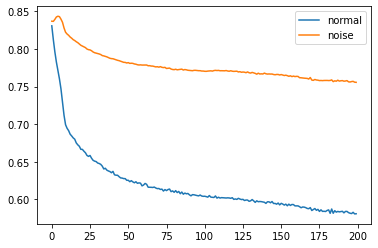

In [ ]:
# load
with open('./sim_weight_top_down/Base_errors_sampling_out_dirty_df_2_ratio07_weight09.pickle', 'rb') as f:
    error = pickle.load(f)
    
# load
with open('./sim_data/choice_idx_2_ratio0.7_weight0.9.pickle', 'rb') as f:
    choice_idx = pickle.load(f)
    
tmp = pd.DataFrame(error[:, :200])
tmp['noise'] = 0
for idx in choice_idx:
    if idx < tmp.shape[0]:
        tmp.iloc[idx, -1] = 1
        
normal = tmp.groupby('noise').mean().values[0]
noise = tmp.groupby('noise').mean().values[1]

plt.plot(normal)
plt.plot(noise)
plt.legend(['normal' ,'noise'])
plt.show()

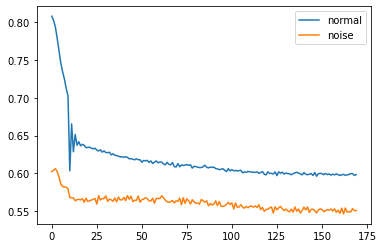

In [ ]:
# load
with open('./sim_weight_top_down/New_errors_sampling_out_dirty_df_2_ratio07_weight05.pickle', 'rb') as f:
    error = pickle.load(f)
    
# load
with open('./sim_data/choice_idx_2_ratio0.7_weight0.5.pickle', 'rb') as f:
    choice_idx = pickle.load(f)
    
tmp = pd.DataFrame(error[:, :170])
tmp['noise'] = 0
for idx in choice_idx:
    if idx < tmp.shape[0]:
        tmp.iloc[idx, -1] = 1
        
normal = tmp.groupby('noise').mean().values[0]
noise = tmp.groupby('noise').mean().values[1]

plt.plot(normal)
plt.plot(noise)
plt.legend(['normal' ,'noise'])
plt.show()

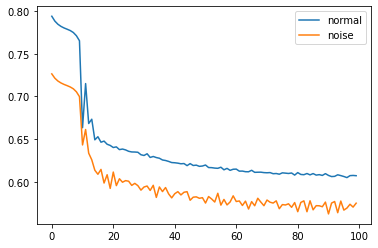

In [ ]:
# load
with open('./sim_weight_top_down/New_errors_sampling_out_dirty_df_2_ratio07_weight01.pickle', 'rb') as f:
    error = pickle.load(f)
    
# load
with open('./sim_data/choice_idx_2_ratio0.7_weight0.1.pickle', 'rb') as f:
    choice_idx = pickle.load(f)
    
tmp = pd.DataFrame(error[:, :100])
tmp['noise'] = 0
for idx in choice_idx:
    if idx < tmp.shape[0]:
        tmp.iloc[idx, -1] = 1
        
normal = tmp.groupby('noise').mean().values[0]
noise = tmp.groupby('noise').mean().values[1]

plt.plot(normal)
plt.plot(noise)
plt.legend(['normal' ,'noise'])
plt.show()